In [5]:
# Some parts of the following code are yet to be parametrized to the general J(n,k) graph
# The used example is J(4,2)
import math
import scipy.special
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile
from qiskit.circuit.library import SwapGate
from qiskit.tools.visualization import plot_histogram

In [6]:
# Johnson graph J(n,k) main parameters
n = 4
k = 2

nstates = int(scipy.special.binom(n, k))  # Number of vertices in a J(n,k) graph
degree = k*(n-k)  # J(n,k) degree
cnum = math.ceil(math.log2(int(scipy.special.binom(n, 2))))  # Required number of qubits for the coin register

state_ = QuantumRegister(n, 'state')  # State register
anci_ = QuantumRegister(n, 'anci')  # Ancillas
coin_ = QuantumRegister(cnum, 'coin')  # Coin register
clas_ = ClassicalRegister(n, 'measure')  # Classical lines
qc = QuantumCircuit(state_, anci_ , coin_, clas_)  # Quantum circuit

In [7]:
# Grover diffuser
grover_op = QuantumCircuit(cnum, name='grover_op')
for i in range(cnum):
    grover_op.h(i)
    grover_op.x(i)
grover_op.h(cnum-1)
grover_op.mcx([i for i in range(0, cnum-1)],[cnum-1])
grover_op.h(cnum-1)
for i in range(cnum):
    grover_op.x(i)
    grover_op.h(i)
grover_gate = grover_op.to_gate()
grover_control_gate = grover_op.to_gate().control(n)

In [8]:
def init():
    # Dicke state initialization on the state register (TODO)
    qc.initialize([
        0, 0, 0, 1/np.sqrt(nstates), 0,
        1/np.sqrt(nstates), 1/np.sqrt(nstates), 0, 0,
        1/np.sqrt(nstates), 1/np.sqrt(nstates), 0, 1/np.sqrt(nstates),
        0, 0, 0
    ], [state_[0], state_[1], state_[2], state_[3]])

    # Uniform superposition initialization on the coin register
    for i in range(cnum):
        qc.h(coin_[i])

In [9]:
# The coin phase first applies a Grover operator regardless of the current state space, then reapplies it according to the oracle's output
# The CNOT gates encode the following matrix:
#  [ 1 1 0 0,
#    1 0 1 1,
#    1 1 1 0,
#    0 1 0 1 ]
# The controlled-Grover application checks whether a k-element subsets of the matrix's columns
#  XORs to the syndrome s = [0, 0, 1, 1]

def coin_phase():
    qc.barrier()
    
    qc.append(grover_gate, [coin_[i] for i in range(cnum)])
    
    qc.cx(state_[0], anci_[0])
    qc.cx(state_[0], anci_[1])
    qc.cx(state_[0], anci_[2])
    qc.cx(state_[1], anci_[0])
    qc.cx(state_[1], anci_[2])
    qc.cx(state_[1], anci_[3])
    qc.cx(state_[2], anci_[1])
    qc.cx(state_[2], anci_[2])
    qc.cx(state_[3], anci_[1])
    qc.cx(state_[3], anci_[3])
    
    qc.barrier()
    
    qc.x(anci_[0])
    qc.x(anci_[1])
    qc.append(grover_control_gate, [anci_[i] for i in range(n)] + [coin_[i] for i in range(cnum)])
    qc.x(anci_[1])
    qc.x(anci_[0])
    
    qc.barrier()
    
    qc.cx(state_[3], anci_[3])
    qc.cx(state_[3], anci_[1])
    qc.cx(state_[2], anci_[2])
    qc.cx(state_[2], anci_[1])
    qc.cx(state_[1], anci_[3])
    qc.cx(state_[1], anci_[2])
    qc.cx(state_[1], anci_[0])
    qc.cx(state_[0], anci_[2])
    qc.cx(state_[0], anci_[1])
    qc.cx(state_[0], anci_[0])

In [10]:
# SWAP sequence (TODO)
swapping = SwapGate().control(num_ctrl_qubits=cnum)
def shift_phase():    
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state_[0], state_[1]])
    qc.x(coin_[0])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state_[2], state_[3]])
    qc.x(coin_[0])
    qc.x(coin_[1])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state_[0], state_[2]])
    qc.x(coin_[0])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state_[1], state_[3]])
    qc.x(coin_[0])
    qc.x(coin_[1])
    qc.x(coin_[2])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state_[0], state_[3]])
    qc.x(coin_[0])
    qc.append(swapping, [coin_[0], coin_[1], coin_[2], state_[1], state_[2]])
    qc.x(coin_[0])
    qc.x(coin_[2])

In [11]:
init()
nsteps = 2
for _ in range(nsteps):
    coin_phase()
    shift_phase()
    
qc.barrier()
qc.measure([state_[i] for i in range(n)], [clas_[i] for i in range(n)])

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


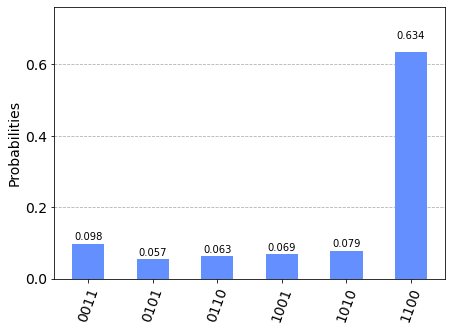

In [12]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

# Run and get counts
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts)

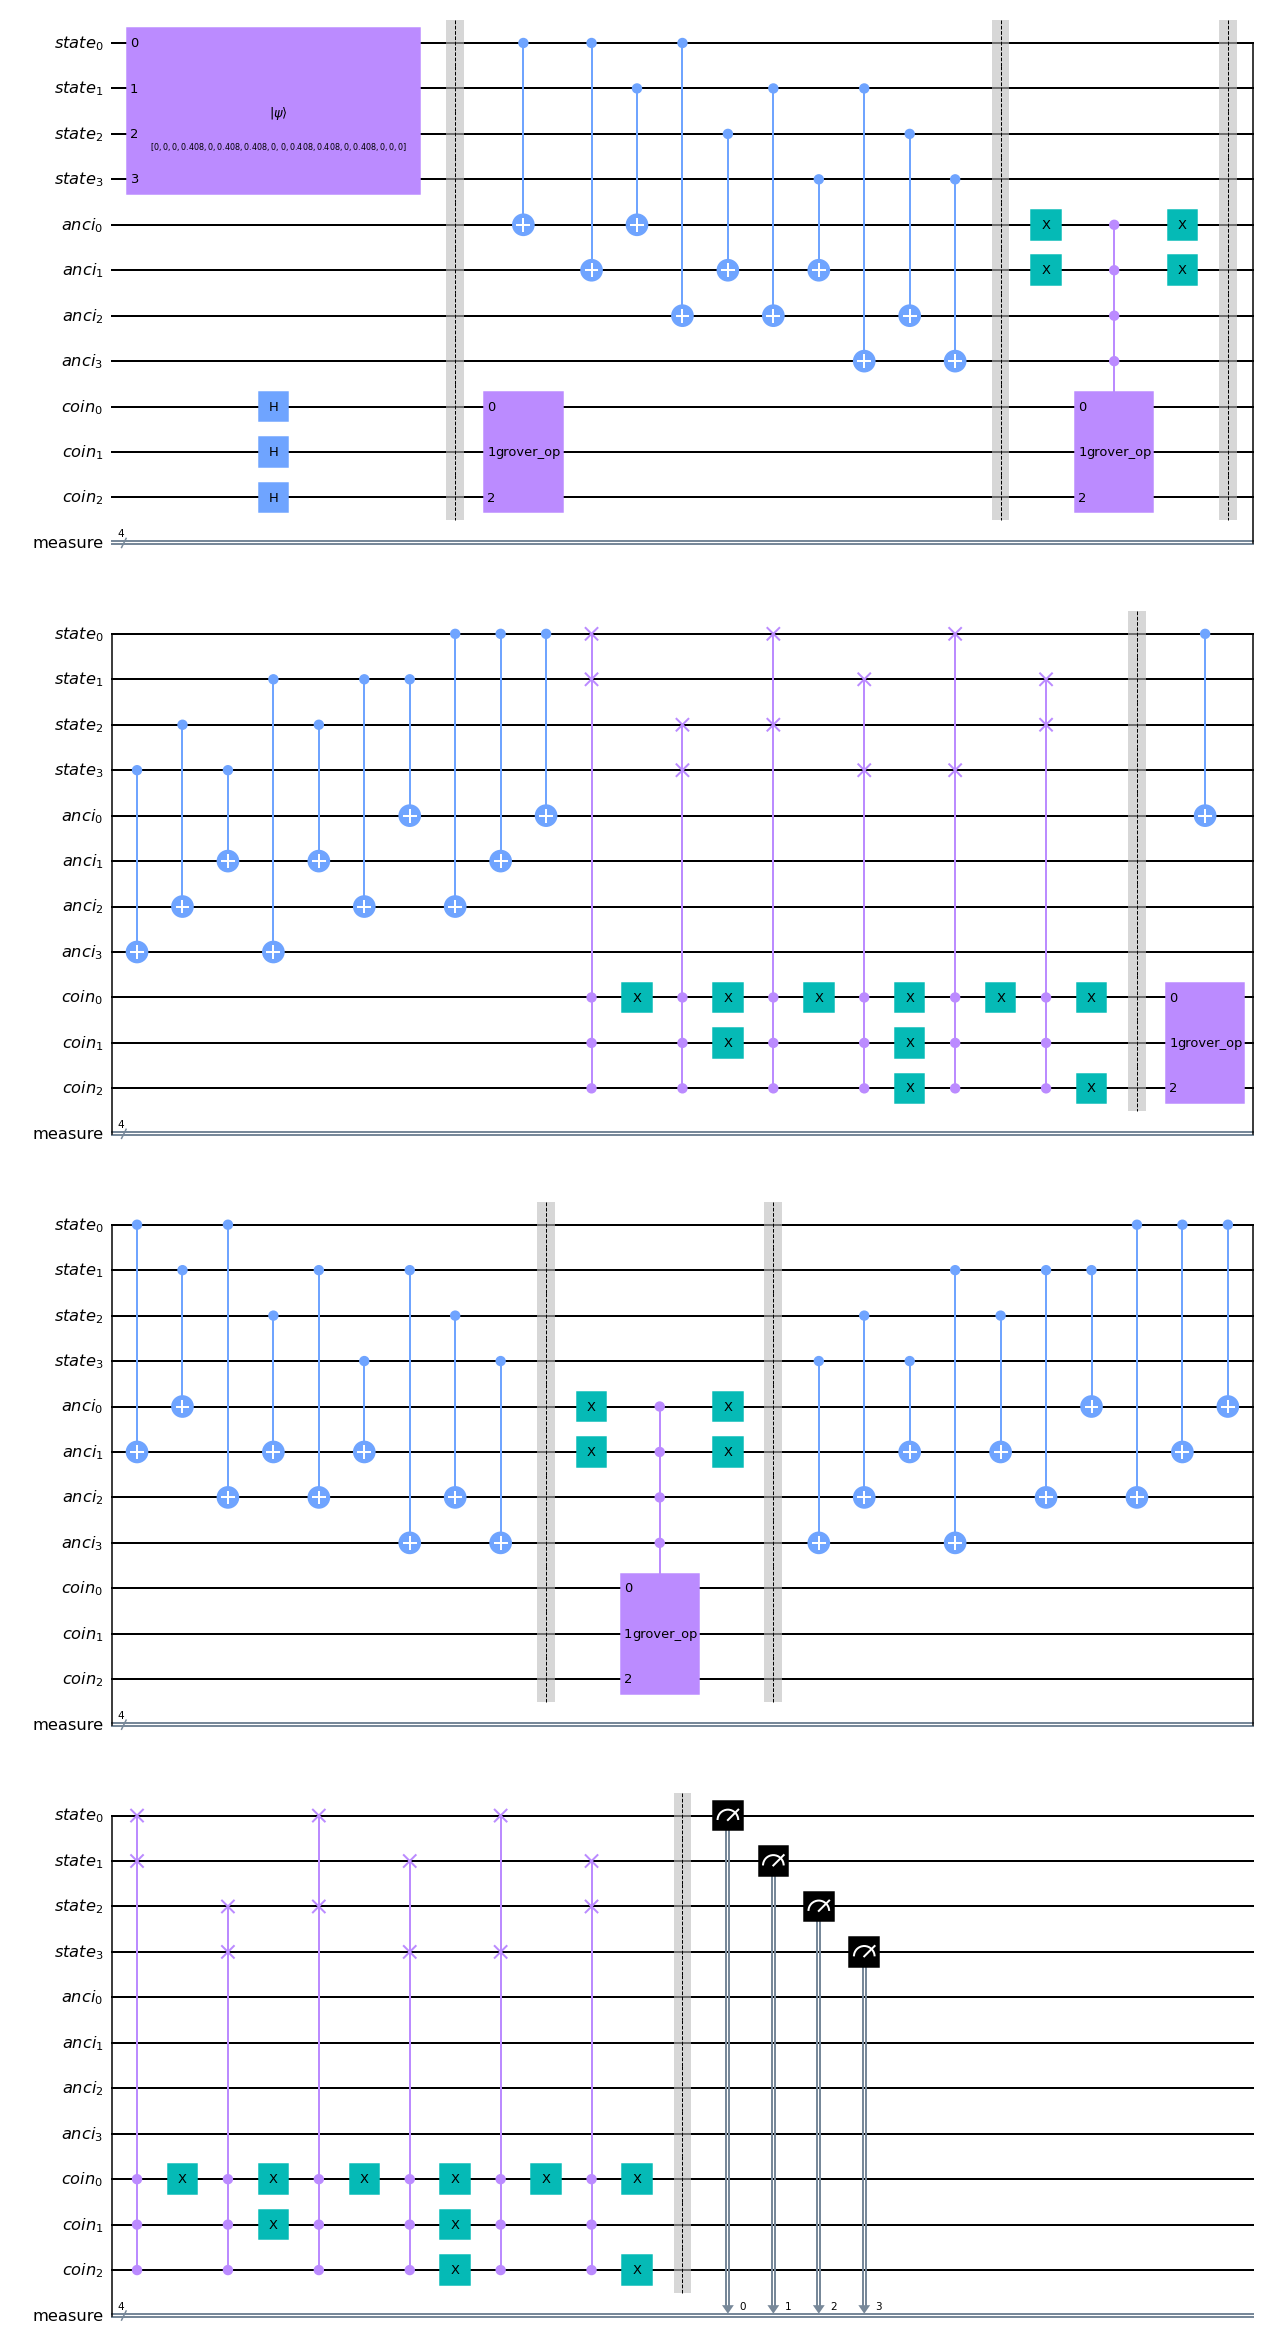

In [10]:
qc.draw()